# Импорт библиотек

In [182]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Определение функций и классов

## Определение функции генерации данных

In [183]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

#---------------------------------
def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

#---------------------------------
def dataset(a, b, f=None,  N=250, x_max=1, noise_power=0, random_x=True,  seed=42):
    np.random.seed(seed)

    if random_x:
        x = np.sort(np.random.rand(N)) * x_max
    else:
        x = np.linspace(0, x_max, N)

    y_true = np.array([])

    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))

    y_true = y_true.reshape(-1, N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

#---------------------------------
def vis_data(y, y_true,x, title):
    fig = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные", s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81, c='g', alpha=0.8)
    plt.grid()
    plt.xlabel('x', fontsize=35)
    plt.ylabel('y', fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25);
    plt.tight_layout()

## Определение функции разделения набора данных на обучающий и тестовый

In [184]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)

    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size <= 1):  train_size = 1 - test_size
        else: train_size = size - test_size

        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size <= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val, y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 

    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

## Определение класса линейной регрессии

In [185]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self, yhat, y):
        return np.square(yhat - y).sum() / y.size
    
    #---------------------------------
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size) / np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1 - np.sum(np.square(y - yhat)) / np.sum(np.square(y - np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size // self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X, y)): 
                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0, y.size, self.batch_size):
            idx_batch = idxs[i_batch:i_batch + self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize=24)
        plt.ylabel('Функция Потерь', fontsize=24)
        plt.title(title, fontsize=24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## Определение класса L2 регуляризации

In [186]:
class RidgeRegression(LinearRegression):
    def __init__(self,
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)

        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty * np.mean(self.weights[1:])
        return self.weights - self.lr * (self.grad + l2_term)

## Определение класса L1 регуляризации

In [187]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)

        self.l1_penalty = l1_penalty

    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty * np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    #---------------------------------
    def update(self):    
        return self.weights - self.lr * (self.grad + np.sign(self.weights) * self.l1_penalty)

# Генерация данных

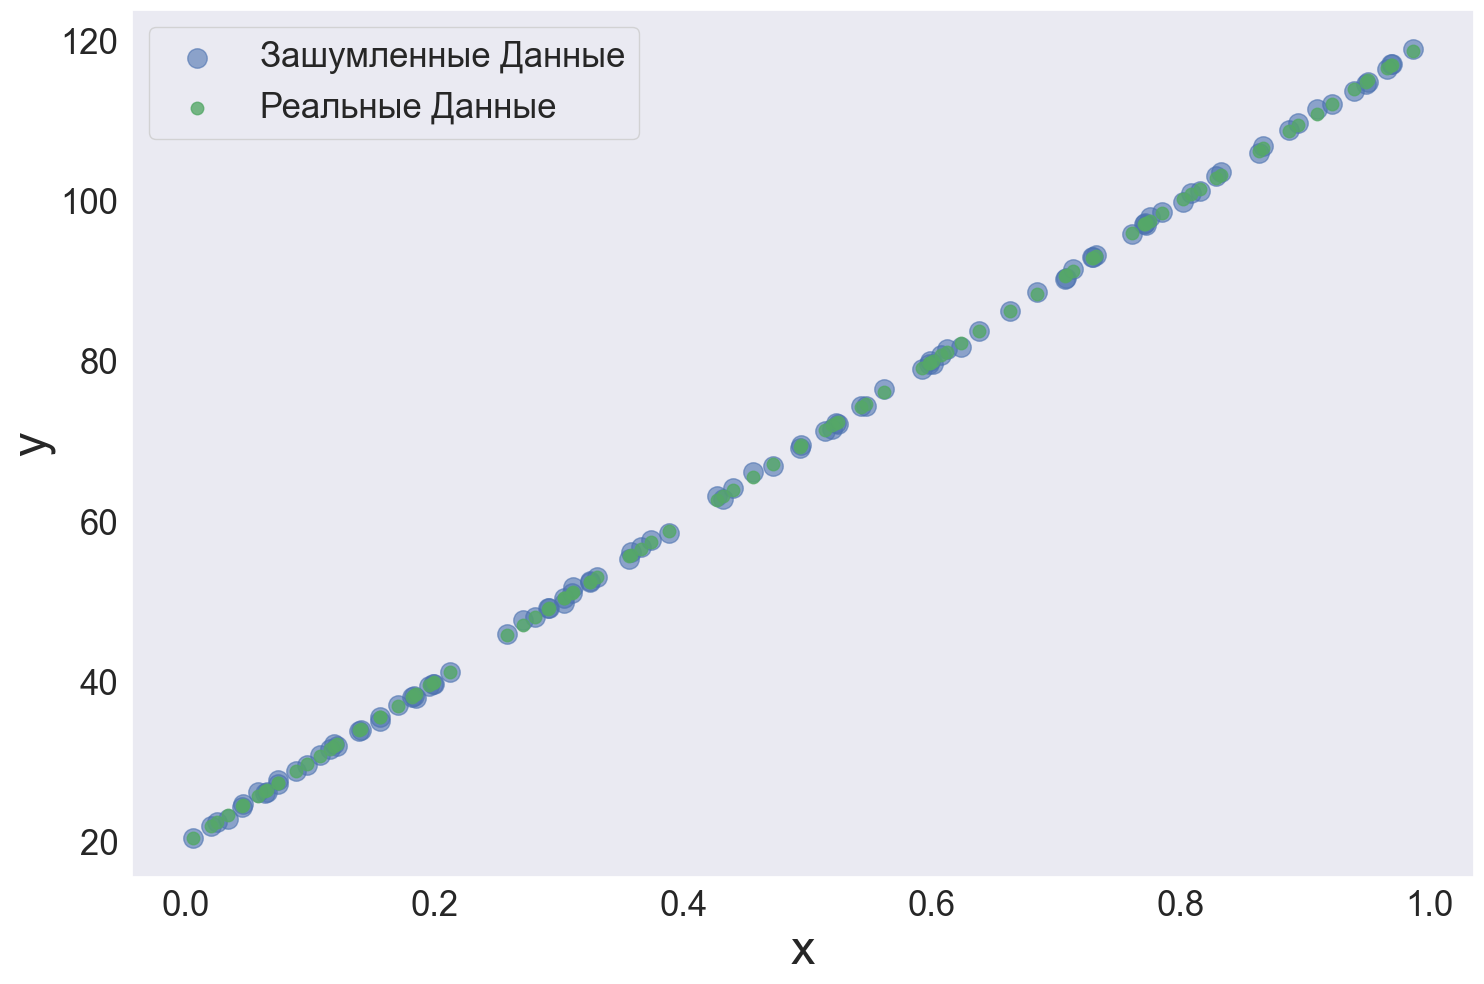

In [188]:
noise_power = 0.3

y_1, y_1_true, x_1 = dataset(
    a=100,
    b=20,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

vis_data(y_1, y_1_true, x_1, 'Линейная зависимость')

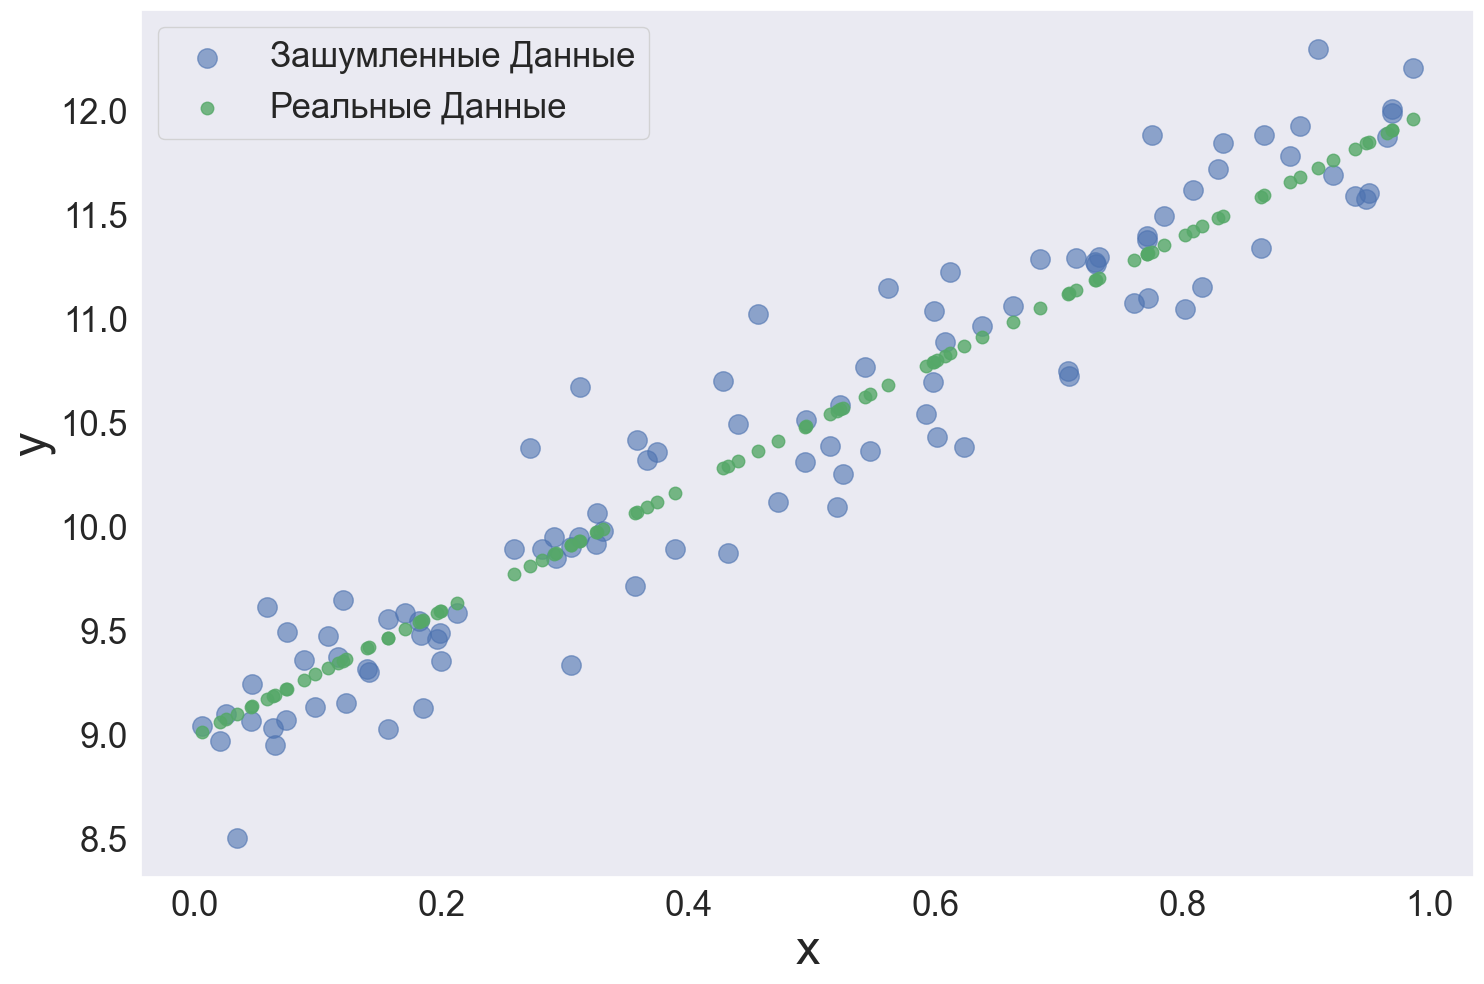

In [189]:
noise_power = 0.3

y, y_true, x = dataset(
    a=3,
    b=9,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

vis_data(y, y_true, x, 'Линейная зависимость')

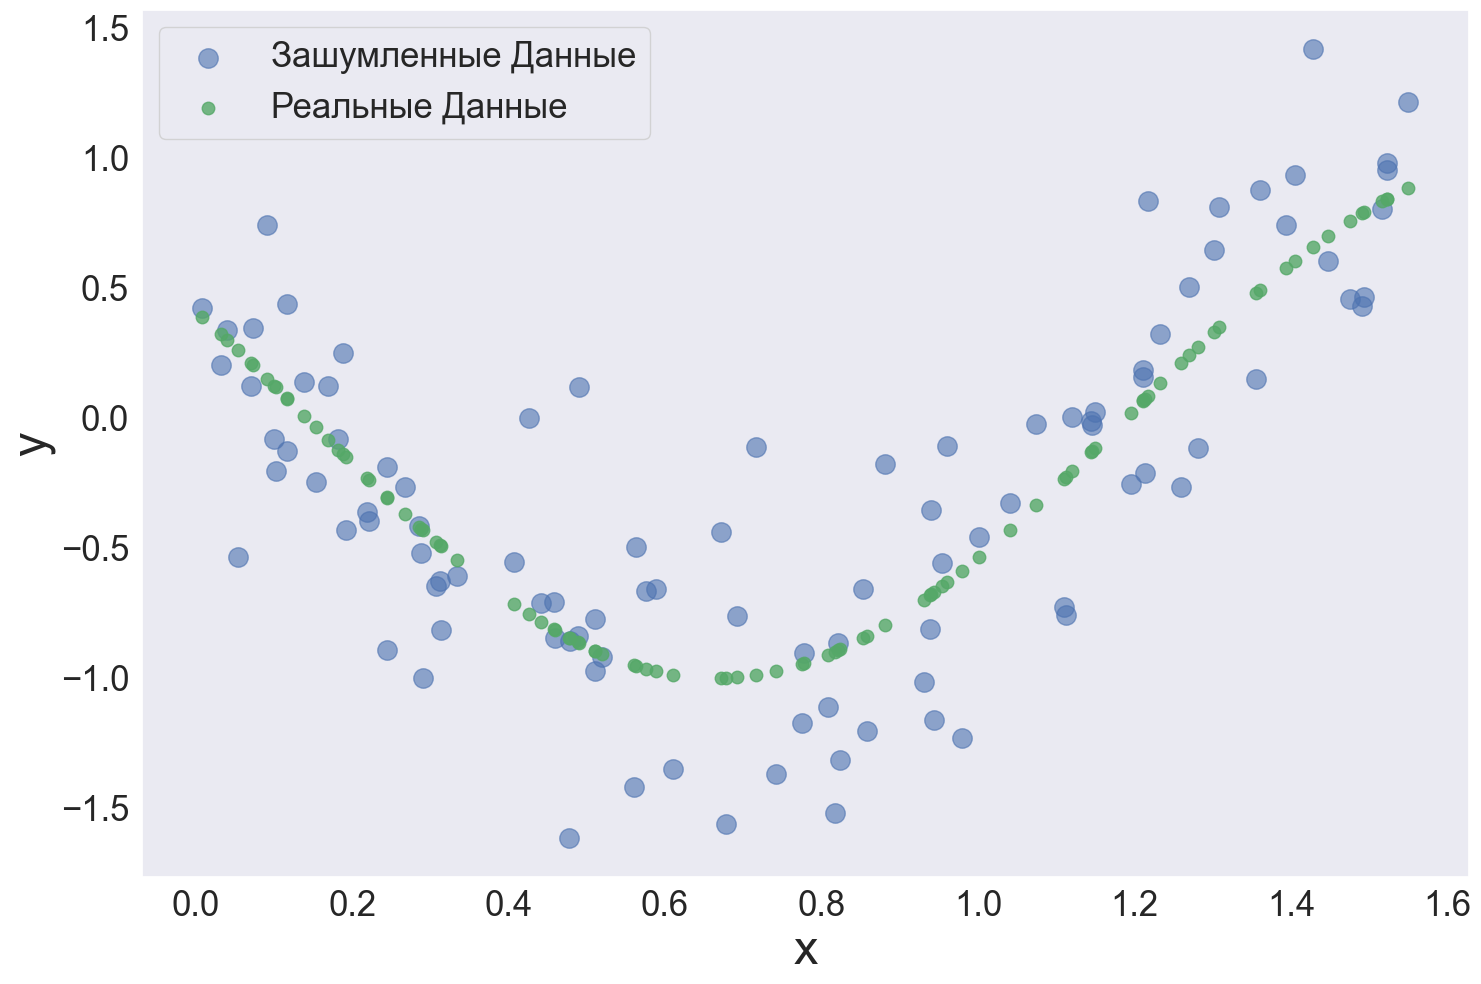

In [190]:
noise_power = 0.4

y, y_true, x = dataset(
    a=3,
    b=9,
    f=np.sin,
    N=100,
    x_max=np.pi/2,
    noise_power=noise_power,
    seed=42
)

vis_data(y, y_true,x, 'Нелинейная зависимость')

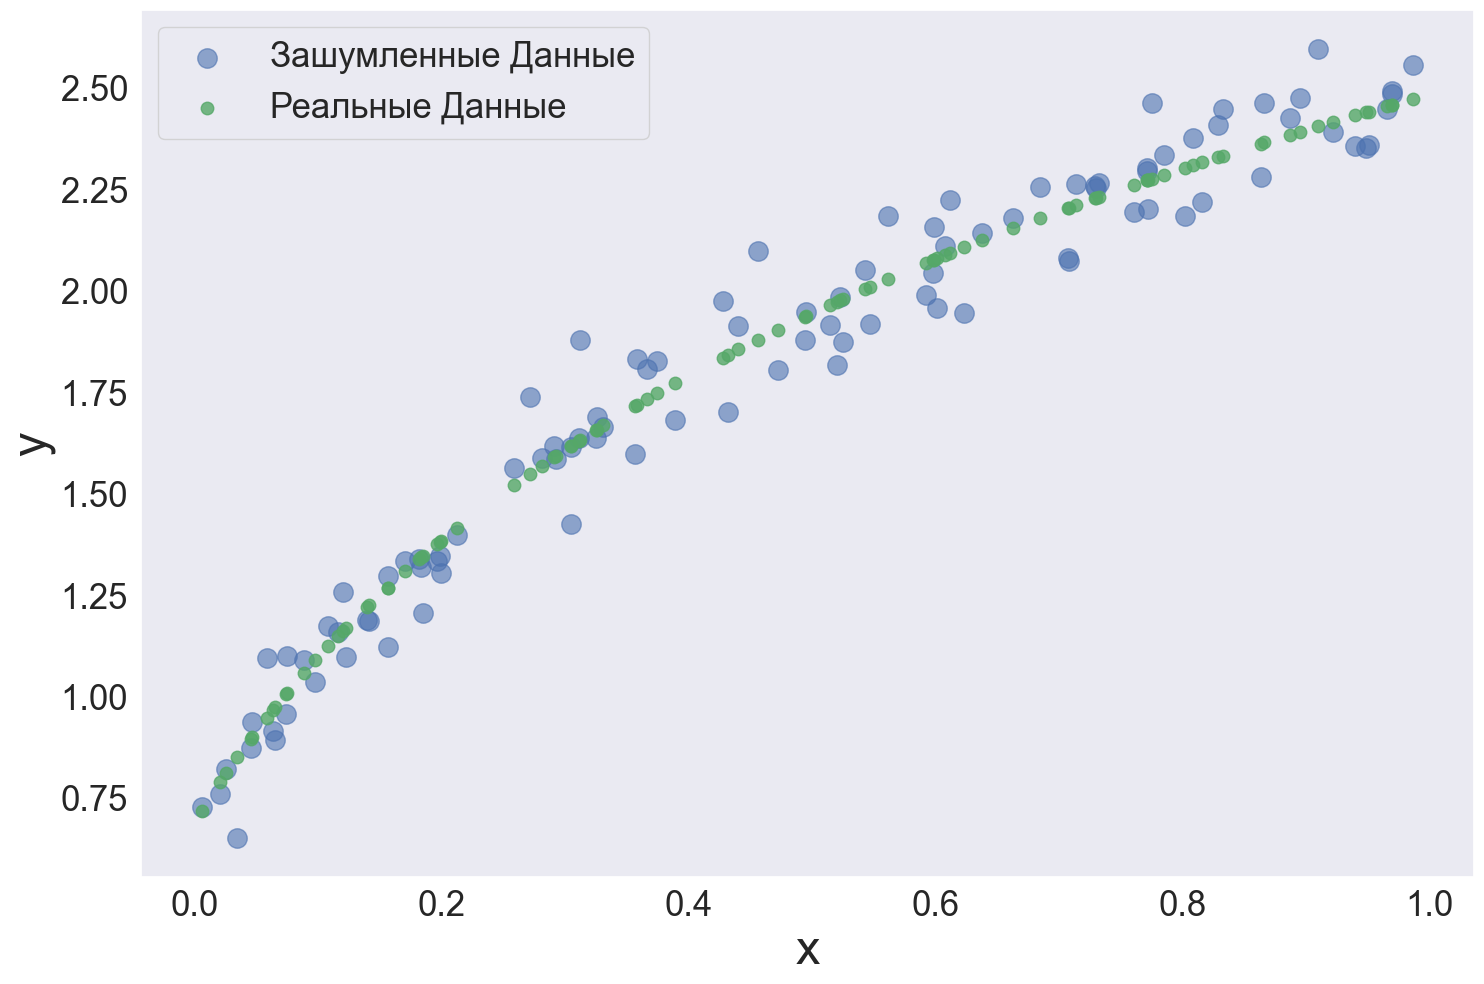

In [191]:
noise_power = 0.1

y, y_true, x = dataset(
    a=10,
    b=2,
    f=np.log,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

vis_data(y, y_true,x, 'Нелинейная зависимость')

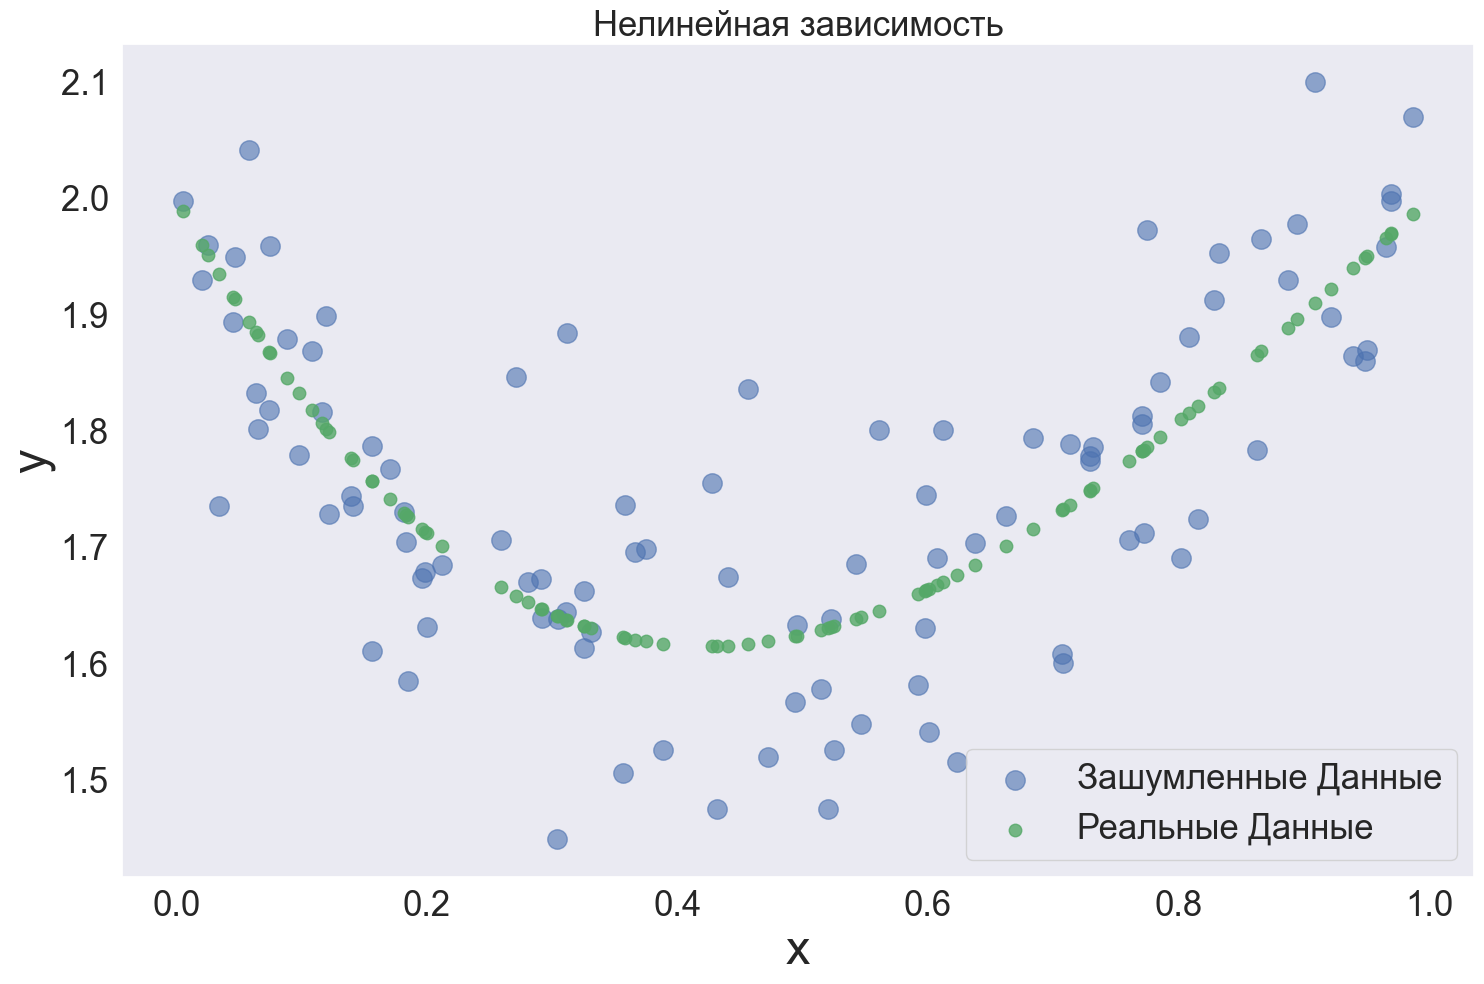

In [193]:
noise_power = 0.1

y, y_true, x = dataset(
    a=[-2, 3, -1],
    b=2,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

vis_data(y, y_true,x, 'Нелинейная зависимость')

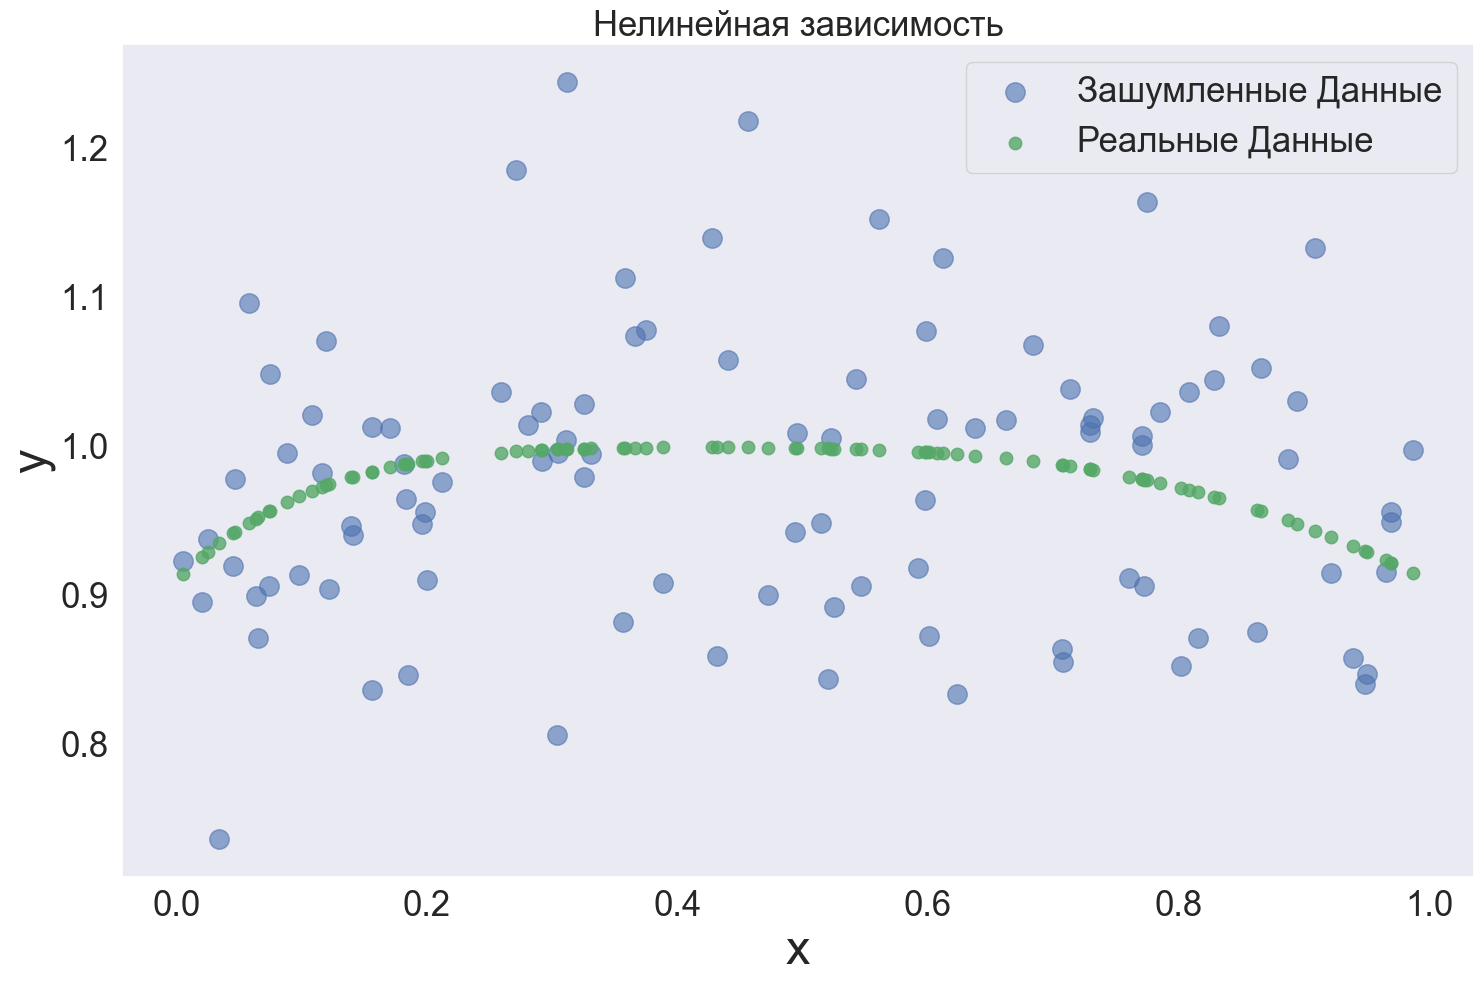

In [194]:
noise_power = 0.1

y, y_true, x = dataset(
    a=[-2, 3, -1],
    b=2,
    f=np.sin,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

vis_data(y, y_true,x, 'Нелинейная зависимость')